# Tensorflow Based

## Importing Packages and Modules

In [14]:
import os
import shutil
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Downloading Dataset from Kaggle

In [2]:
# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file, Replace kaggle.json with your own Token
shutil.move("kaggle.json", "/root/.kaggle/")

# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

# create directories
os.mkdir("figures")
os.mkdir("history")
os.mkdir("models")

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:14<00:00, 60.4MB/s]
100% 2.29G/2.29G [00:14<00:00, 165MB/s] 


In [4]:
# Unzip the dataset
with zipfile.ZipFile("/content/chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Dataset extracted successfully!")

Dataset extracted successfully!


## Loading and Splitting the Dataset

In [5]:
# Load dataset and split into train/val sets
BATCH_SIZE = 32
IMG_SIZE = 224
CHANNEL = 3


train_dir = "/content/dataset/chest_xray/train/"
val_dir = "/content/dataset/chest_xray/val/"
test_dir = "/content/dataset/chest_xray/test/"


## train,test, and validation datasets
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = (IMG_SIZE,IMG_SIZE),
    label_mode = 'binary',
    batch_size = BATCH_SIZE,
    shuffle = True
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = (IMG_SIZE,IMG_SIZE),
    label_mode = 'binary',
    batch_size = BATCH_SIZE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = val_dir,
    image_size = (IMG_SIZE,IMG_SIZE),
    label_mode = 'binary',
    batch_size = BATCH_SIZE
)

# The number of classes
class_names = val_data.class_names
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print(f"Class Names: {class_names}")

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Class Names: ['NORMAL', 'PNEUMONIA']


## Dataset Visualization

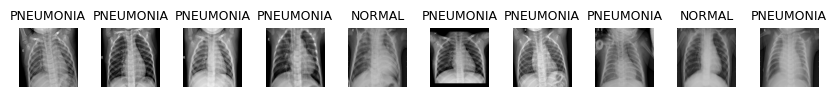

In [6]:
# Take one batch
for batch in train_data.take(1):  # Get a single batch
    images, labels = batch  # Unpack images and labels
    images = images.numpy()  # Convert to NumPy for plotting

# Select random images to plot
num_images_to_plot = 10
random_indices = np.random.choice(images.shape[0], num_images_to_plot, replace=False)

# Plot images
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    top=0.3, # padding to the top in order to have a clear subplots
                    right=0.9,
                    wspace=0.4,
                    hspace=0.4)

for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(images[idx].astype("uint8"))       #
    plt.title(class_names[int(labels[i][0])], fontsize=9)
    plt.axis("off")

plt.show()

## Data Augmentation

In [7]:
# Data augmentation
# stack all necessary preprocessing layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.3),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.Rescaling(1./255)
], name ="data_augmentation")

## Building  Model

In [8]:
# Build a simple model
# defining the model
model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), padding="valid"),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), padding="valid"),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), padding="valid"),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), padding="valid"),
        tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D'),
        tf.keras.layers.Dense(2, activation='sigmoid', name='output_layer')
])

# build the model
model.build(input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL))

## Compile the Model

In [9]:
# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy']
)

## Train Model

In [11]:
# Train the model and monitor validation loss/accuracy
history = model.fit(
    train_data,
    epochs=30,
    validation_data = val_data,
    validation_steps = len(val_data),
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 834ms/step - accuracy: 0.7243 - loss: 0.5925 - val_accuracy: 0.5000 - val_loss: 0.7602
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 830ms/step - accuracy: 0.7316 - loss: 0.5740 - val_accuracy: 0.4375 - val_loss: 0.7014
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 817ms/step - accuracy: 0.7419 - loss: 0.5448 - val_accuracy: 0.5625 - val_loss: 0.6558
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 801ms/step - accuracy: 0.7828 - loss: 0.4664 - val_accuracy: 0.6250 - val_loss: 0.7191
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 814ms/step - accuracy: 0.7497 - loss: 0.5018 - val_accuracy: 0.5625 - val_loss: 0.8538
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 792ms/step - accuracy: 0.8006 - loss: 0.4296 - val_accuracy: 0.6250 - val_loss: 0.8532
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 821ms/step - accuracy: 0.8128 - loss: 0.4138 - val_accuracy: 0.6250 - val_loss: 1.2848
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 831ms/step - accuracy: 0.8242 -

## Visualizing Metrics

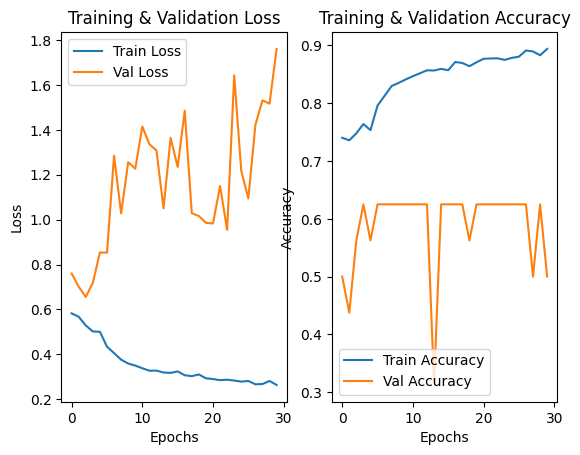

In [12]:
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.savefig("figures/Train_Val_Loss_TF.png")

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.savefig("figures/Train_Val_Accuracy_TF.png")

plt.show()

## Save history

In [15]:
history_TF = pd.DataFrame(history.history)

In [17]:
history_TF.to_csv("history/history_TF.csv", index=False)

## Save the Model

In [18]:
model.save('models/tensorflow_based_model.keras')

## Evalution on Test

In [19]:
model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.8384 - loss: 0.4022


[0.4387582242488861, 0.8237179517745972]

In [20]:
predictions = model.predict(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step


In [21]:
predictions = np.argmax(predictions, axis=-1)

## Visualizing Test Metrics

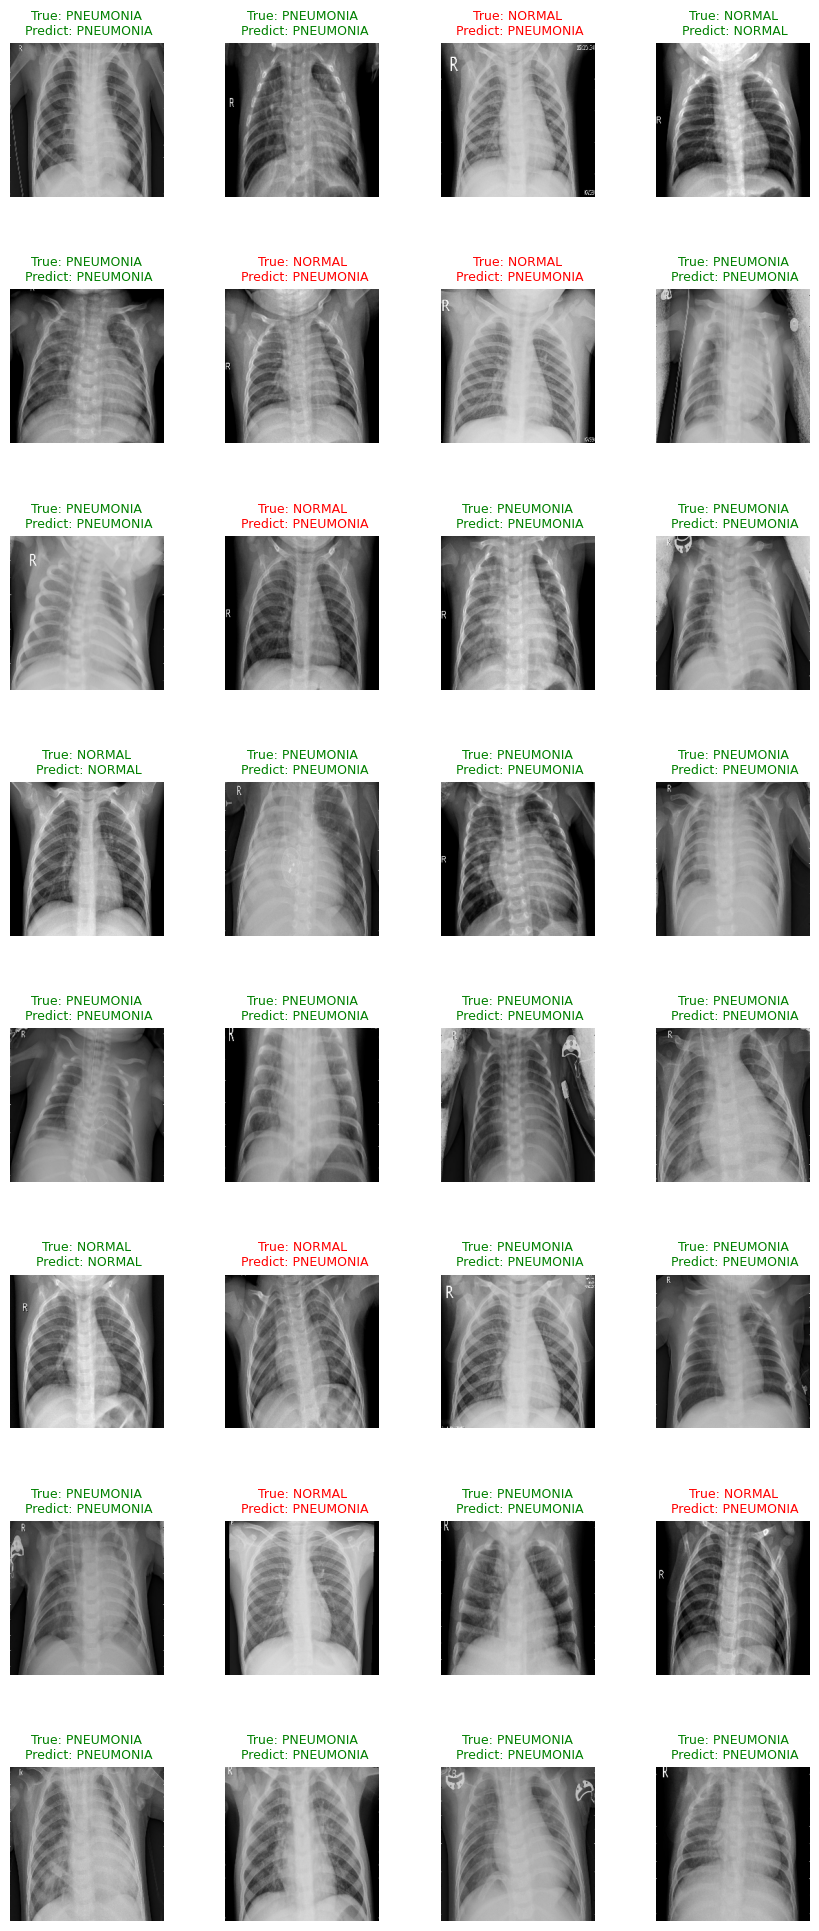

In [22]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=2, # padding to the top in order to have a clear subplots
                    wspace=0.4,
                    hspace=0.4)


for batch_images,labels in test_data.take(1):
  for i in range(0,32):
    # print(batch_images[i].numpy().astype("uint32").shape)
    plt.subplot(8,4,i+1)
    plt.imshow(batch_images[i].numpy().astype("uint32"))
    true_class = class_names[int(labels[i][0])]
    predict_class = model.predict(batch_images[i].numpy().astype("uint32").reshape(1,224,224,3), verbose=0)
    predict_class = class_names[np.argmax(predict_class)]
    title = f"True: {true_class}\n Predict: {predict_class}"
    plt.title(title, color='g' if true_class==predict_class else 'r', fontsize=9)
    plt.axis("off")